In [1]:
!pip install chardet
!pip install tensorflow-addons

In [2]:
import os
import glob
import numpy as np
import tqdm
import yaml
import pandas as pd
import uuid
import datetime
import time
import tensorflow_addons as tfa
from collections import defaultdict

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN, GCNSupervisedGraphClassification
from stellargraph import StellarDiGraph
from sklearn import model_selection

import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from spektral.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from matplotlib import pyplot as plt

%matplotlib inline

2021-07-28 19:49:37.099560: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-28 19:49:38.565659: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-28 19:49:38.599910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-28 19:49:38.600444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2021-07-28 19:49:38.600466: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-28 19:49:38.602874: I tensorflow/stream_executor/platfor

In [3]:
data_dir = '/home/nonroot/experiment/results/notebook/simplify-vs-cse'
info_file = os.path.join(data_dir, 'info.yaml')
representations = ['cfgcompact', 'cfgcallcompactnoroot', 'cfgcallcompact1enoroot']
features = ['boo', 'i2v', 'w2v']

In [4]:
def yaml_load(filename: str):
    with open(filename, 'rt') as f:
        return yaml.load(f, Loader=yaml.FullLoader)
    
files = yaml_load(info_file)

In [5]:
def create_graph(filename):
    data = np.load(filename, allow_pickle=True)
    indexes, features = zip(*data['nodes'])
    node_data = pd.DataFrame(features, index=indexes)
    edges = pd.DataFrame(data['edges'], columns=['source', 'target', 'type'])
    return StellarDiGraph(node_data, edges=edges, edge_type_column="type")

def get_features(data_dir, files, features, representations):
    for rep in representations:
        for feature in features:
            graphs = []
            labels = []
            for f in tqdm.tqdm(files, desc=f"Representation: {rep}. Features: {feature}."):
                graph_file = os.path.join(data_dir, f"{f}_{feature}.npz")
                graph = create_graph(graph_file)
                class_file = os.path.join(data_dir, f"{f}_classes.yaml")
                info = yaml_load(class_file)
                min_value = min(c['binary_size'] for c in info)
                label = [1 if c['binary_size'] == min_value else 0 for c in info].index(1)    
                graphs.append(graph)
                labels.append(label)
                
            graph_labels = pd.DataFrame(labels, columns=['labels'])
            graph_labels = pd.get_dummies(graph_labels, drop_first=True)
            name = f"{rep}-{feature}"
            yield graphs, graph_labels, name
            

In [6]:
def create_GCN_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    # model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])
    return model

def create_DGCNN_classification_model(generator, k):
    layer_sizes = [32, 32, 32, 1]

    dgcnn_model = DeepGraphCNN(
        layer_sizes=layer_sizes,
        activations=["tanh", "tanh", "tanh", "tanh"],
        k=k,
        bias=False,
        generator=generator,
    )
    x_inp, x_out = dgcnn_model.in_out_tensors()
    x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
    x_out = MaxPool1D(pool_size=2)(x_out)
    x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)
    x_out = Flatten()(x_out)
    x_out = Dense(units=128, activation="relu")(x_out)
    x_out = Dropout(rate=0.5)(x_out)
    predictions = Dense(units=1, activation="sigmoid")(x_out)
    
    model = Model(inputs=x_inp, outputs=predictions)
    # model.compile(optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"])
    return model

In [7]:
def get_train_test_sets(graphs, graph_labels, train_size, validation_size, test_size, train_batch_size, validation_batch_size, test_batch_size):
    train_graphs, test_graphs = model_selection.train_test_split(
        graph_labels,
        train_size=train_size,
        test_size=test_size,
        stratify=graph_labels,
    )

    train_graphs, val_graphs = model_selection.train_test_split(
        train_graphs,
        train_size=train_size,
        test_size=validation_size,
        stratify=train_graphs,
    )

    gen = PaddedGraphGenerator(graphs=graphs)

    train_gen = gen.flow(
        list(train_graphs.index - 1),
        targets=train_graphs.values,
        batch_size=train_batch_size,
        symmetric_normalization=False,
    )

    val_gen = gen.flow(
        list(val_graphs.index - 1),
        targets=val_graphs.values,
        batch_size=validation_batch_size,
        symmetric_normalization=False,
    )

    test_gen = gen.flow(
        list(test_graphs.index - 1),
        targets=test_graphs.values,
        batch_size=test_batch_size,
        symmetric_normalization=False,
    )

    print("Generated Data")
    return train_gen, val_gen, test_gen

In [8]:
def generate_plot(history, output):
    figure = plt.figure()
    plt.plot(np.array(history.history['acc']))
    plt.plot(np.array(history.history['val_acc']))
    plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')  
    plt.savefig(output, bbox_inches='tight')
    plt.show()

In [9]:
networks = {
    'gcn': {},
    'dgcnn': {'k': 35}
}

data_configs = [
#    {
#        'train_size': 0.9,
#        'validation_size': 0.1,
#        'test_size': 0.1,
#        'train_batch_size': 64,
#        'validation_batch_size': 16,
#        'test_batch_size': 16
#    },
    {
        'train_size': 0.9,
        'validation_size': 0.1,
        'test_size': 0.1,
        'train_batch_size': 128,
        'validation_batch_size': 16,
        'test_batch_size': 16
    },
    
]

train_configs = [
    {
        'epochs': 1000,
        'shuffle': True,
        'verbose': False
    }
]

graphs_generator = get_features(data_dir, files, features, representations)
output_dir = '/home/nonroot/experiment/results/notebook/experiments/'
os.makedirs(output_dir, exist_ok=True)

Representation: cfgcompact. Features: boo.: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 125.79it/s]


Generated Data
[2021-07-28 19:50:01.551292] Starting to train with: exp_name=cfgcompact-boo-gcn-6cfffc70, net=gcn, net-args={}, data_config={'train_size': 0.9, 'validation_size': 0.1, 'test_size': 0.1, 'train_batch_size': 128, 'validation_batch_size': 16, 'test_batch_size': 16}, train_conf={'epochs': 1000, 'shuffle': True, 'verbose': False}


Training:   0%|                                                                                               …

2021-07-28 19:50:01.630114: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-28 19:50:01.649401: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz
2021-07-28 19:50:02.188159: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-28 19:50:02.391722: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


Train took 491.231 seconds
Max acc train: 0.6839506030082703. Max acc val: 0.5666666626930237
Weights saved to: /home/nonroot/experiment/results/notebook/experiments/cfgcompact-boo-gcn-6cfffc70_weights.h5


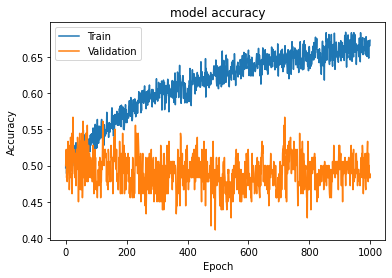

Graph saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-boo-gcn-6cfffc70_accuracy.pdf
Info saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-boo-gcn-6cfffc70_info.yaml
Generated Data
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
[2021-07-28 19:58:18.994872] Starting to train with: exp_name=cfgcompact-boo-dgcnn-481283b8, net=dgcnn, net-args={'k': 35}, data_config={'train_size': 0.9, 'validation_size': 0.1, 'test_size': 0.1, 'train_batch_size': 128, 'validation_batch_size': 16, 'test_batch_size': 16}, train_conf={'epochs': 1000, 'shuffle': True, 'verbose': False}


Training:   0%|                                                                                               …

/home/nonroot/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/sort_pooling/map/while/gradients/model_1/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/sort_pooling/map/while/gradients/model_1/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/sort_pooling/map/while/gradients/model_1/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
2021-07-28 19:58:20.009029: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-28 19:58:20.204419: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-07-28 19:58:20.

Train took 1128.151 seconds
Max acc train: 0.8500000238418579. Max acc val: 0.5833333134651184
Weights saved to: /home/nonroot/experiment/results/notebook/experiments/cfgcompact-boo-dgcnn-481283b8_weights.h5


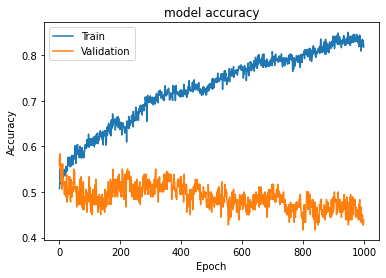

Graph saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-boo-dgcnn-481283b8_accuracy.pdf
Info saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-boo-dgcnn-481283b8_info.yaml


Representation: cfgcompact. Features: i2v.: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:44<00:00, 44.81it/s]


Generated Data
[2021-07-28 20:17:57.811348] Starting to train with: exp_name=cfgcompact-i2v-gcn-c30dfaa9, net=gcn, net-args={}, data_config={'train_size': 0.9, 'validation_size': 0.1, 'test_size': 0.1, 'train_batch_size': 128, 'validation_batch_size': 16, 'test_batch_size': 16}, train_conf={'epochs': 1000, 'shuffle': True, 'verbose': False}


Training:   0%|                                                                                               …

Train took 620.305 seconds
Max acc train: 0.550000011920929. Max acc val: 0.5722222328186035
Weights saved to: /home/nonroot/experiment/results/notebook/experiments/cfgcompact-i2v-gcn-c30dfaa9_weights.h5


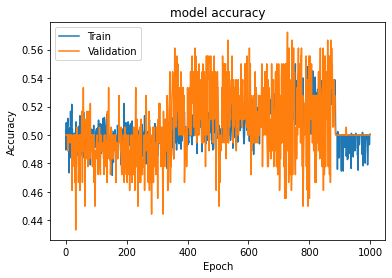

Graph saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-i2v-gcn-c30dfaa9_accuracy.pdf
Info saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-i2v-gcn-c30dfaa9_info.yaml
Generated Data
[2021-07-28 20:28:24.083709] Starting to train with: exp_name=cfgcompact-i2v-dgcnn-20e737ff, net=dgcnn, net-args={'k': 35}, data_config={'train_size': 0.9, 'validation_size': 0.1, 'test_size': 0.1, 'train_batch_size': 128, 'validation_batch_size': 16, 'test_batch_size': 16}, train_conf={'epochs': 1000, 'shuffle': True, 'verbose': False}


Training:   0%|                                                                                               …

/home/nonroot/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/sort_pooling_1/map/while/gradients/model_3/sort_pooling_1/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_3/sort_pooling_1/map/while/gradients/model_3/sort_pooling_1/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/sort_pooling_1/map/while/gradients/model_3/sort_pooling_1/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train took 1185.878 seconds
Max acc train: 0.8617283701896667. Max acc val: 0.6111111044883728
Weights saved to: /home/nonroot/experiment/results/notebook/experiments/cfgcompact-i2v-dgcnn-20e737ff_weights.h5


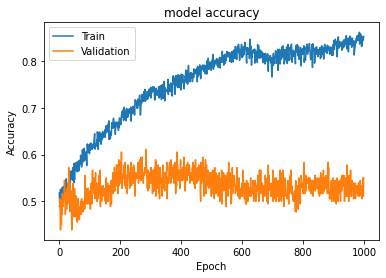

Graph saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-i2v-dgcnn-20e737ff_accuracy.pdf
Info saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-i2v-dgcnn-20e737ff_info.yaml


Representation: cfgcompact. Features: w2v.: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.81it/s]


Generated Data
[2021-07-28 20:49:18.721644] Starting to train with: exp_name=cfgcompact-w2v-gcn-3e10ce1e, net=gcn, net-args={}, data_config={'train_size': 0.9, 'validation_size': 0.1, 'test_size': 0.1, 'train_batch_size': 128, 'validation_batch_size': 16, 'test_batch_size': 16}, train_conf={'epochs': 1000, 'shuffle': True, 'verbose': False}


Training:   0%|                                                                                               …

Train took 628.791 seconds
Max acc train: 0.5493826866149902. Max acc val: 0.605555534362793
Weights saved to: /home/nonroot/experiment/results/notebook/experiments/cfgcompact-w2v-gcn-3e10ce1e_weights.h5


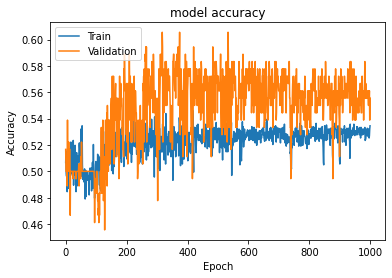

Graph saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-w2v-gcn-3e10ce1e_accuracy.pdf
Info saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-w2v-gcn-3e10ce1e_info.yaml
Generated Data
[2021-07-28 20:59:53.623588] Starting to train with: exp_name=cfgcompact-w2v-dgcnn-2689c14a, net=dgcnn, net-args={'k': 35}, data_config={'train_size': 0.9, 'validation_size': 0.1, 'test_size': 0.1, 'train_batch_size': 128, 'validation_batch_size': 16, 'test_batch_size': 16}, train_conf={'epochs': 1000, 'shuffle': True, 'verbose': False}


Training:   0%|                                                                                               …

/home/nonroot/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/sort_pooling_2/map/while/gradients/model_5/sort_pooling_2/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_5/sort_pooling_2/map/while/gradients/model_5/sort_pooling_2/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_5/sort_pooling_2/map/while/gradients/model_5/sort_pooling_2/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train took 1230.171 seconds
Max acc train: 0.9117283821105957. Max acc val: 0.5555555820465088
Weights saved to: /home/nonroot/experiment/results/notebook/experiments/cfgcompact-w2v-dgcnn-2689c14a_weights.h5


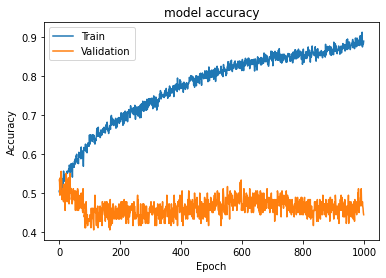

Graph saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-w2v-dgcnn-2689c14a_accuracy.pdf
Info saved to /home/nonroot/experiment/results/notebook/experiments/cfgcompact-w2v-dgcnn-2689c14a_info.yaml


Representation: cfgcallcompactnoroot. Features: boo.: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 127.43it/s]


Generated Data
[2021-07-28 21:20:45.527453] Starting to train with: exp_name=cfgcallcompactnoroot-boo-gcn-9858077e, net=gcn, net-args={}, data_config={'train_size': 0.9, 'validation_size': 0.1, 'test_size': 0.1, 'train_batch_size': 128, 'validation_batch_size': 16, 'test_batch_size': 16}, train_conf={'epochs': 1000, 'shuffle': True, 'verbose': False}


Training:   0%|                                                                                               …

Train took 415.401 seconds
Max acc train: 0.6950617432594299. Max acc val: 0.5555555820465088
Weights saved to: /home/nonroot/experiment/results/notebook/experiments/cfgcallcompactnoroot-boo-gcn-9858077e_weights.h5


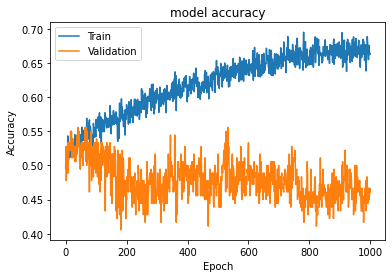

Graph saved to /home/nonroot/experiment/results/notebook/experiments/cfgcallcompactnoroot-boo-gcn-9858077e_accuracy.pdf
Info saved to /home/nonroot/experiment/results/notebook/experiments/cfgcallcompactnoroot-boo-gcn-9858077e_info.yaml
Generated Data
[2021-07-28 21:27:46.897603] Starting to train with: exp_name=cfgcallcompactnoroot-boo-dgcnn-88dddf42, net=dgcnn, net-args={'k': 35}, data_config={'train_size': 0.9, 'validation_size': 0.1, 'test_size': 0.1, 'train_batch_size': 128, 'validation_batch_size': 16, 'test_batch_size': 16}, train_conf={'epochs': 1000, 'shuffle': True, 'verbose': False}


Training:   0%|                                                                                               …

/home/nonroot/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_7/sort_pooling_3/map/while/gradients/model_7/sort_pooling_3/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_7/sort_pooling_3/map/while/gradients/model_7/sort_pooling_3/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_7/sort_pooling_3/map/while/gradients/model_7/sort_pooling_3/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [ ]:
for graphs, graph_labels, rep_name in graphs_generator:
    generator = PaddedGraphGenerator(graphs=graphs)
    for net, args in networks.items():            
        for data_conf in data_configs:
            train_gen, val_gen, test_gen = get_train_test_sets(graphs, graph_labels, **data_conf)
            for train_conf in train_configs:
                if net == 'gcn':
                    model = create_GCN_classification_model(generator, **args)
                    model.compile(optimizer=Adam(learning_rate=0.005), loss=binary_crossentropy, metrics=["acc"])
                elif net == 'dgcnn':
                    model = create_DGCNN_classification_model(generator, **args)
                    model.compile(optimizer=Adam(learning_rate=0.0001), loss=binary_crossentropy, metrics=["acc"])
                else:
                    raise ValueError(f"Invalid network `{net}`")
                
                tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
                exp_name = f'{rep_name}-{net}-{str(uuid.uuid4())[:8]}'
                
                print(f"[{datetime.datetime.now()}] Starting to train with: exp_name={exp_name}, net={net}, net-args={args}, data_config={data_conf}, train_conf={train_conf}")
                start_time = time.time()
                history = model.fit(train_gen, validation_data=val_gen, callbacks=[tqdm_callback], **train_conf)
                end_time = time.time()
                print(f"Train took {end_time-start_time:.3f} seconds")
                
                max_acc_train = max(history.history['acc'])
                max_acc_val = max(history.history['val_acc'])
                print(f"Max acc train: {max_acc_train}. Max acc val: {max_acc_val}")
                
                weights_file = os.path.join(output_dir, f"{exp_name}_weights.h5")
                model.save_weights(weights_file)
                print(f"Weights saved to: {weights_file}")
                
                acc_plot_file = os.path.join(output_dir, f'{exp_name}_accuracy.pdf')
                generate_plot(history, acc_plot_file)
                print(f"Graph saved to {acc_plot_file}")
                
                info_dict = {
                    'rep': rep_name,
                    'net': net,
                    'net-args': args,
                    'data_config': data_conf,
                    'train_config': train_conf,
                    'history': history.history,
                    'train_time': end_time-start_time,
                    'max_acc_train': max_acc_train,
                    'max_acc_val': max_acc_val
                }
                info_file = os.path.join(output_dir, f'{exp_name}_info.yaml')
                with open(info_file, 'wt') as f:
                    yaml.dump(info_dict, f)
                print(f"Info saved to {info_file}")
                
print(f"[{datetime.datetime.now()}] FINISHED!")

In [ ]:
print('ok')